In [67]:
import re
import os
import sys
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from collections import Counter, namedtuple
from Bio.Align import AlignInfo, MultipleSeqAlignment
import importlib
from Sequence import Sequence
from Util.SeqUtil import seqInfo, parseFasta
from Evaluation.DfamEvaluation import DfamEvaluation
from DataStructure import PositionInfo, refSeqSimilarityInfo
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot
from MultipleCutter import MultipleCutter
importlib.reload(sys.modules['Sequence'])

<module 'Sequence' from '/Users/apple/Desktop/BioProject/GenomeAnalysis/src/Sequence.py'>

In [68]:
# ROO_LTR_df = pd.read_csv("./Evaluation/Source/chrX_ROO_LTR_repeatSeq.csv")
# ROO_counter = Counter(list(ROO_LTR_df['length']))
# ROO_counter.most_common(len(ROO_counter))

In [69]:
currDatasetName = "chrX_dm6"

In [70]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs(lengthLimit=True)
filterRepeatInfoA = seqA.filterRepeatInfo()
repeatPositionListA = seqA.getRepeatPositionList(filter=True)

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.14527511596679688 sec to parse fasta file ...
...start parse seq by cutter: GATC
...cost 0.23754000663757324 sec to cut sequence
... start finding repeat seq ...
...cost0.06335282325744629 sec to finding repeat seq  ...


In [71]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs(lengthLimit=True)
filterRepeatInfoB = seqB.filterRepeatInfo()
repeatPositionListB = seqB.getRepeatPositionList(filter=True)

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.12192511558532715 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 0.3181111812591553 sec to cut sequence
... start finding repeat seq ...
...cost0.006268978118896484 sec to finding repeat seq  ...


In [72]:
seqInfo(currDatasetName, parseFastaA)

chrX_dm6 dataset
 number of sequence:1
 total length:23542271



In [73]:
repeatPositionList = repeatPositionListA + repeatPositionListB

In [74]:
print(f'Check cutter A, B: \n {len(repeatPositionList)} = {len(repeatPositionListA)} + {len(repeatPositionListB)}')

Check cutter A, B: 
 7145 = 6980 + 165


In [75]:
repeatPositionList[0]

PositionInfo(startIdx=432, endIdx=647)

In [76]:
# repeat position
multipleCutter = MultipleCutter(chrLength=len(parseFastaA[0]),repeatPositionList = repeatPositionList )
seqStateList = multipleCutter.seqStateGenerator()
unMatchState, unionState, intersectionState = multipleCutter.getSeqStateInfo()
stateName="union"
matchStateIdxList = multipleCutter.getSpecificStateIdxList(stateName)
matchStatePositionList = multipleCutter.getSpecificStatePositionList()
# Output MultipleCutter State Position
textfile = open(f"../outputFile/txtFile/{stateName}StatePosition.txt", "w")
for element in matchStatePositionList:
    textfile.write(str(element) + "\n")
textfile.close()

chr: 23542271
unMatch: 22655652, union:811516, intersection:75103


In [77]:
len(matchStatePositionList)

56

In [78]:
repeatPositionList = matchStatePositionList

In [79]:
dfam = DfamEvaluation(repeatPositionList, hitFileName='chrX_LTR_dm6_dfam.nrph.hits')

In [80]:
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

In [81]:
len(dfamPositionList)

602

In [82]:
# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

In [83]:
# from repeat , check Dfam
# RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

In [84]:
# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:13	dfamCount:602	Ratio:0.02159468438538206


0.02159468438538206

In [85]:
# dfam.familyMatchRatio(RDmatchedFamilyAccList)
# dfam.matchRatio(RDrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(RDrepeatMatchList)

In [86]:
# lengthScatterDistributionPlot(list(unMatchDf["length"]))

In [87]:
def getSequenceLengthAnalsis(inputLengthList, num=10):
    """
    1. count of common length 
    2. statistic info
    3. distribution plot
    """
    mostCommonTable(Counter(inputLengthList).most_common(num), num)
    getStatisticData(inputLengthList)
    sortedCounterList = listToSortedCounter(inputLengthList)
    basicPlot(sortedCounterList)

In [88]:
totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
totalDfamPositionList = totalDfam.getDfamPositionList()
totalList = [ i.endIdx - i.startIdx  for i in totalDfamPositionList]
totalSortedCounterList = listToSortedCounter(totalList)

In [89]:
dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
LTRSortedCounterList = listToSortedCounter(dfamSeqLenList)

(0.0, 1500.0)

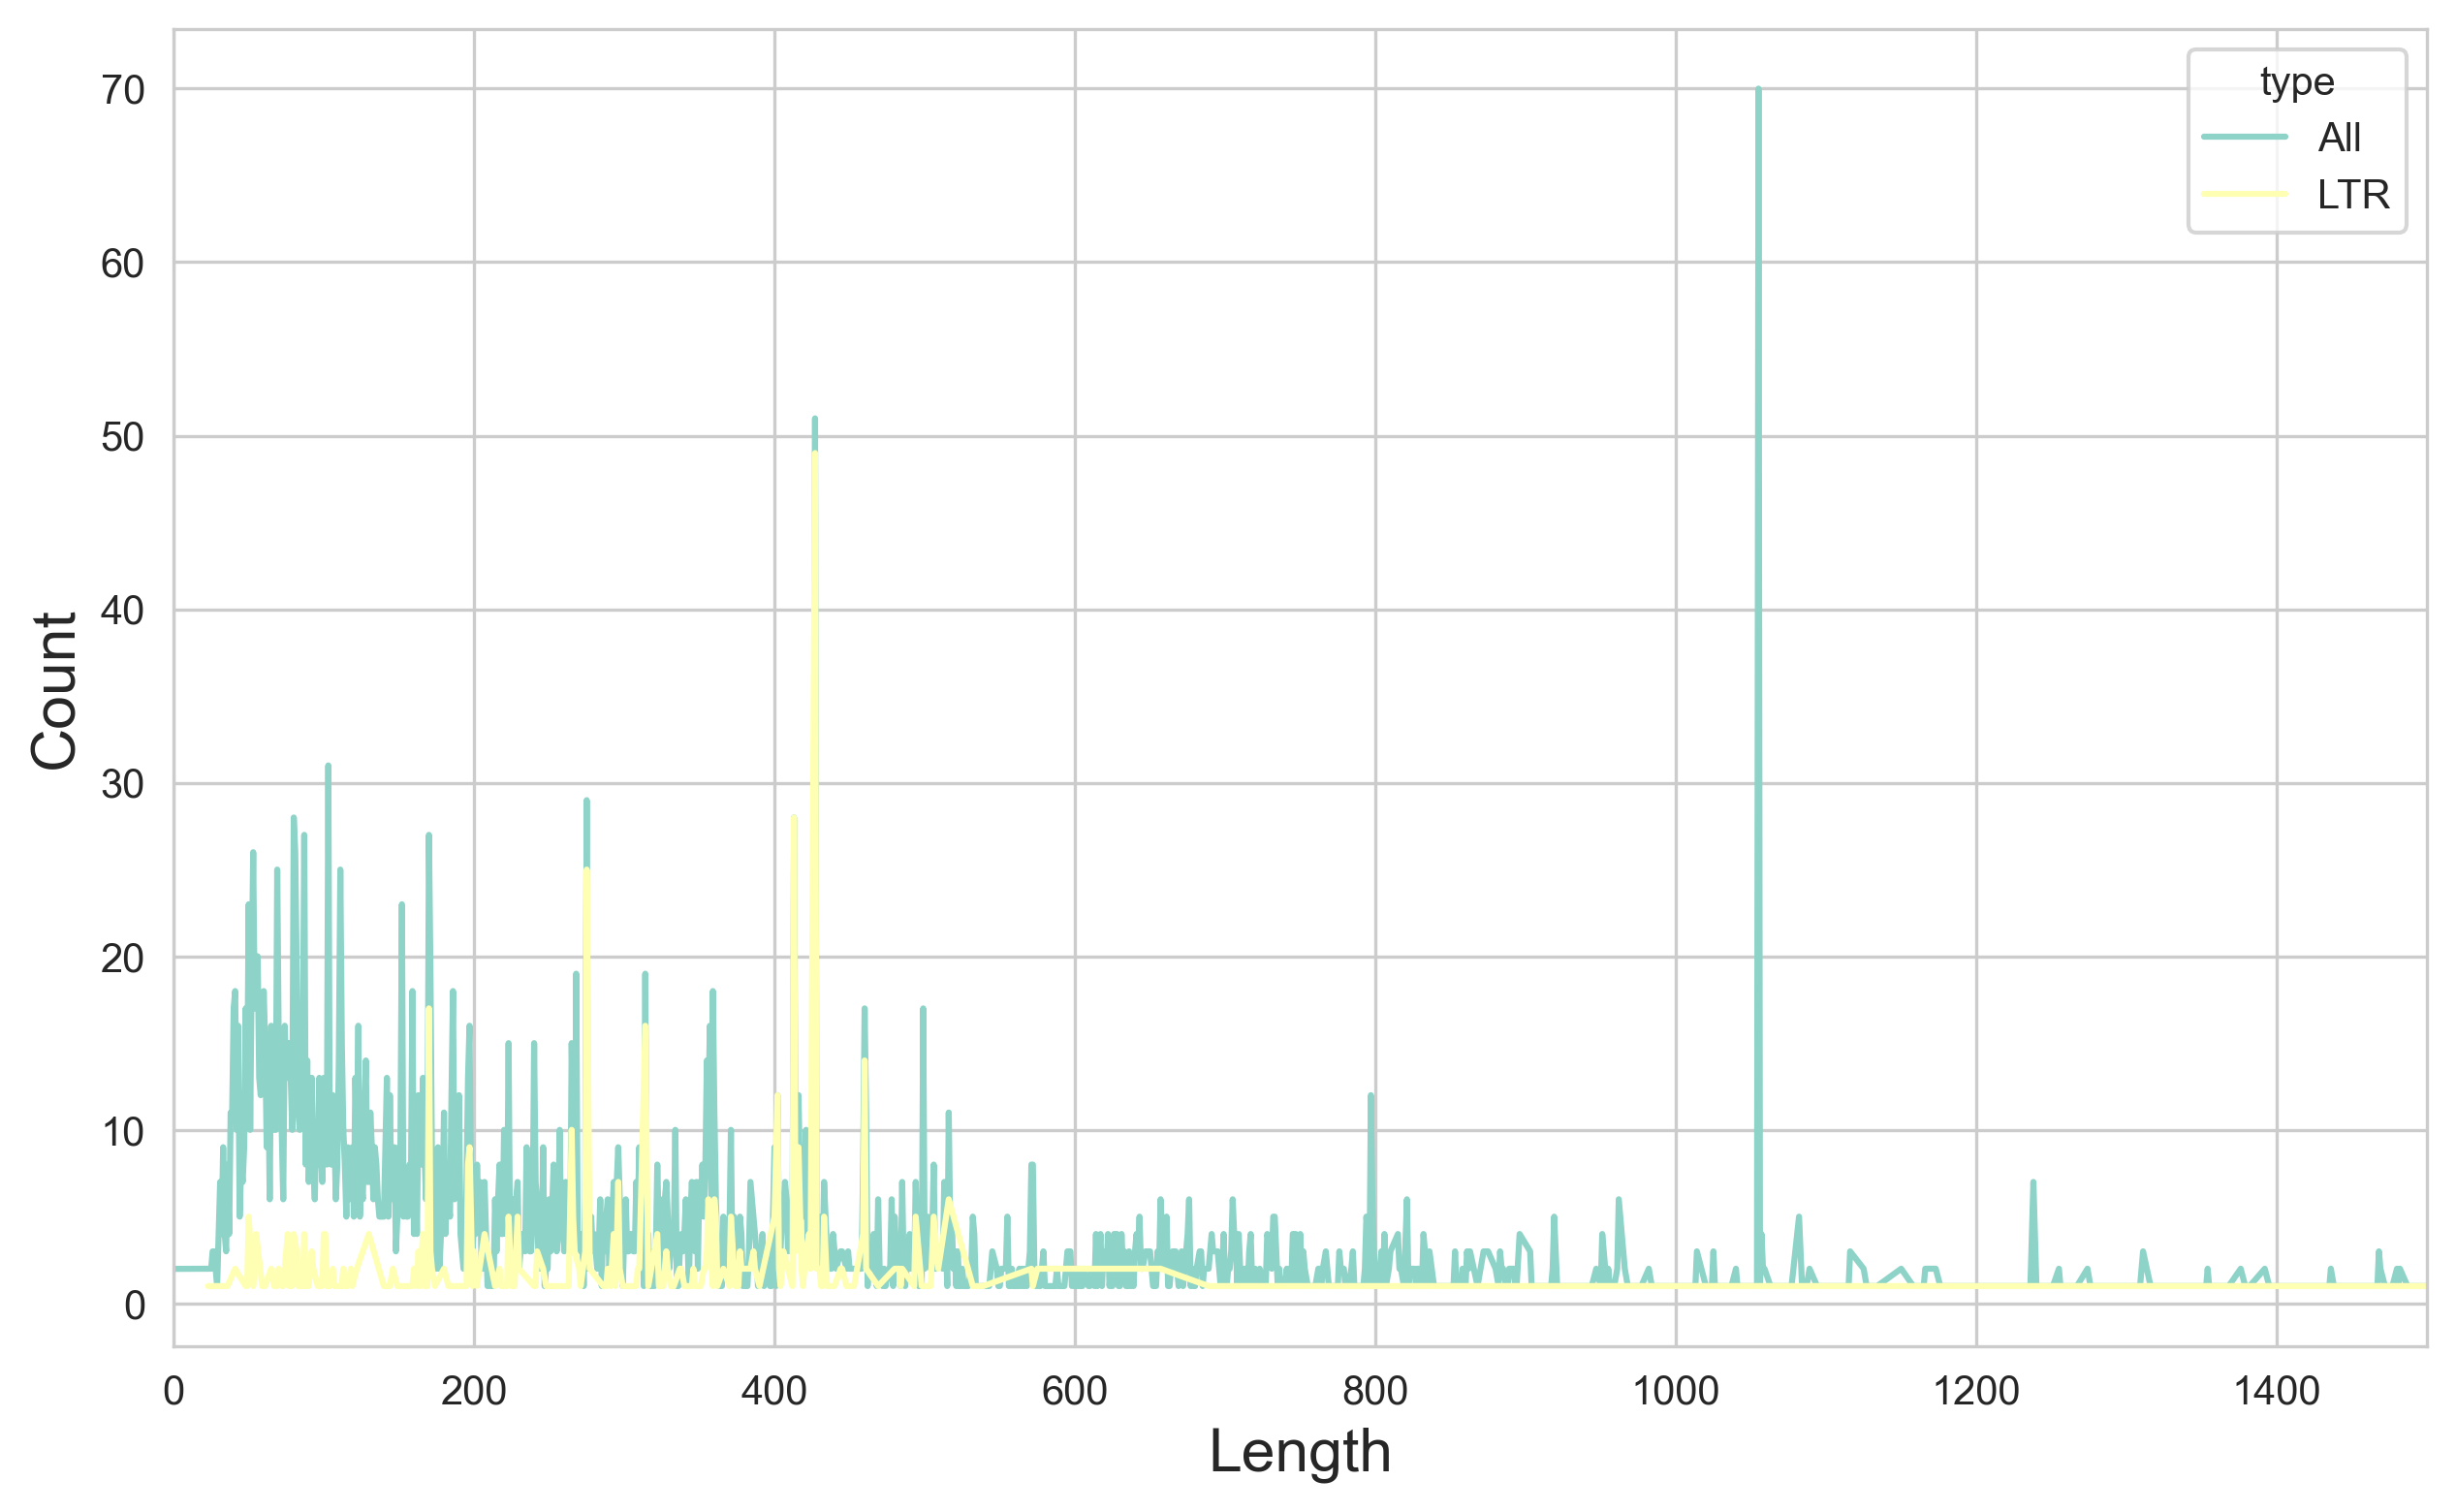

In [90]:
df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
for row in totalSortedCounterList:
    df = df.append({"x": row[0], "y": row[1], "type": "All"}, ignore_index=True)
for row in LTRSortedCounterList:
    df = df.append({"x": row[0], "y": row[1], "type": "LTR"}, ignore_index=True)

df.fillna(np.nan, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")
sns.lineplot(data=df, x="x", y="y", hue="type")
ax.set_xlabel("Length", size=15)
ax.set_ylabel("Count", size=15)
ax.set_xlim(0, 1500)

In [91]:
# Dfam ref sequence 
# dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
# getSequenceLengthAnalsis(dfamSeqLenList)

In [92]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [93]:
# def consensusSeqSimilarity(consensusSeq, seqDf):
#     print("hihi", len(seqDf))
#     seqSimilarityList = []
#     for targetSeq in seqDf:
#         alignments = pairwise2.align.globalxx(targetSeq, consensusSeq)
#         targetLength = len(targetSeq)
#         similarityPercentage = round(alignments[0].score / targetLength, 2)
#         seqSimilarityList.append(similarityPercentage)
#     return seqSimilarityList

# repeatMatchIdxList = []
# for idx, value in enumerate(RDrepeatMatchList):
#     if value == True:
#         repeatMatchIdxList.append(idx)
# repeatBasePositionList = [repeatPositionList[i] for i in repeatMatchIdxList]
# repeatSeqDf = pd.DataFrame(columns=['startIdx','endIdx', 'length', 'seq'])
# for i in repeatBasePositionList:
#     repeatSeqDf = repeatSeqDf.append({'startIdx':i.startIdx ,'endIdx': i.endIdx, 'length': (i.endIdx- i.startIdx), 'seq': str(parseFastaA[0][i.startIdx:i.endIdx])}, ignore_index=True)
# conParseFasta = parseFasta(
#     "DF0001696_ROO_LTR",
#     "./Evaluation/Source/DF0001696_ROO_LTR.fa",
#     "*",
#     matchMode=False,
# )
# consensusSeq = conParseFasta[0].upper()
# repeatDf = pd.read_csv('./Evaluation/Source/chrX_ROO_LTR_repeatSeq.csv')
# seqDf = repeatDf["seq"]
# seqSimilarityList = consensusSeqSimilarity(consensusSeq, seqDf)
# pd.Series(seqSimilarityList).describe()

In [94]:
# Test cutter A
repeatPositionListA = seqA.getRepeatPositionList()
dfamA = DfamEvaluation(repeatPositionListA)
repeatPositionLookupDicA = dfamA.positionBucketClassifier()
dfamPositionListA = dfamA.getDfamPositionList()
dfamPositionLookupDicA = dfamA.positionBucketClassifier()
DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [95]:
totalLen = len(DRrepeatMatchListA)
matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
ratio = matchLenA / totalLen
print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

matchCount:133	dfamCount:602	Ratio:0.22093023255813954


In [96]:
# Test cutter B
repeatPositionListB = seqB.getRepeatPositionList()
dfamB = DfamEvaluation(repeatPositionListB)
repeatPositionLookupDicB = dfamB.positionBucketClassifier()
dfamPositionListB = dfamB.getDfamPositionList()
dfamPositionLookupDicB = dfamB.positionBucketClassifier()
DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [97]:
totalLen = len(DRrepeatMatchListB)
matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
ratio = matchLenB / totalLen
print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

matchCount:16	dfamCount:602	Ratio:0.026578073089700997


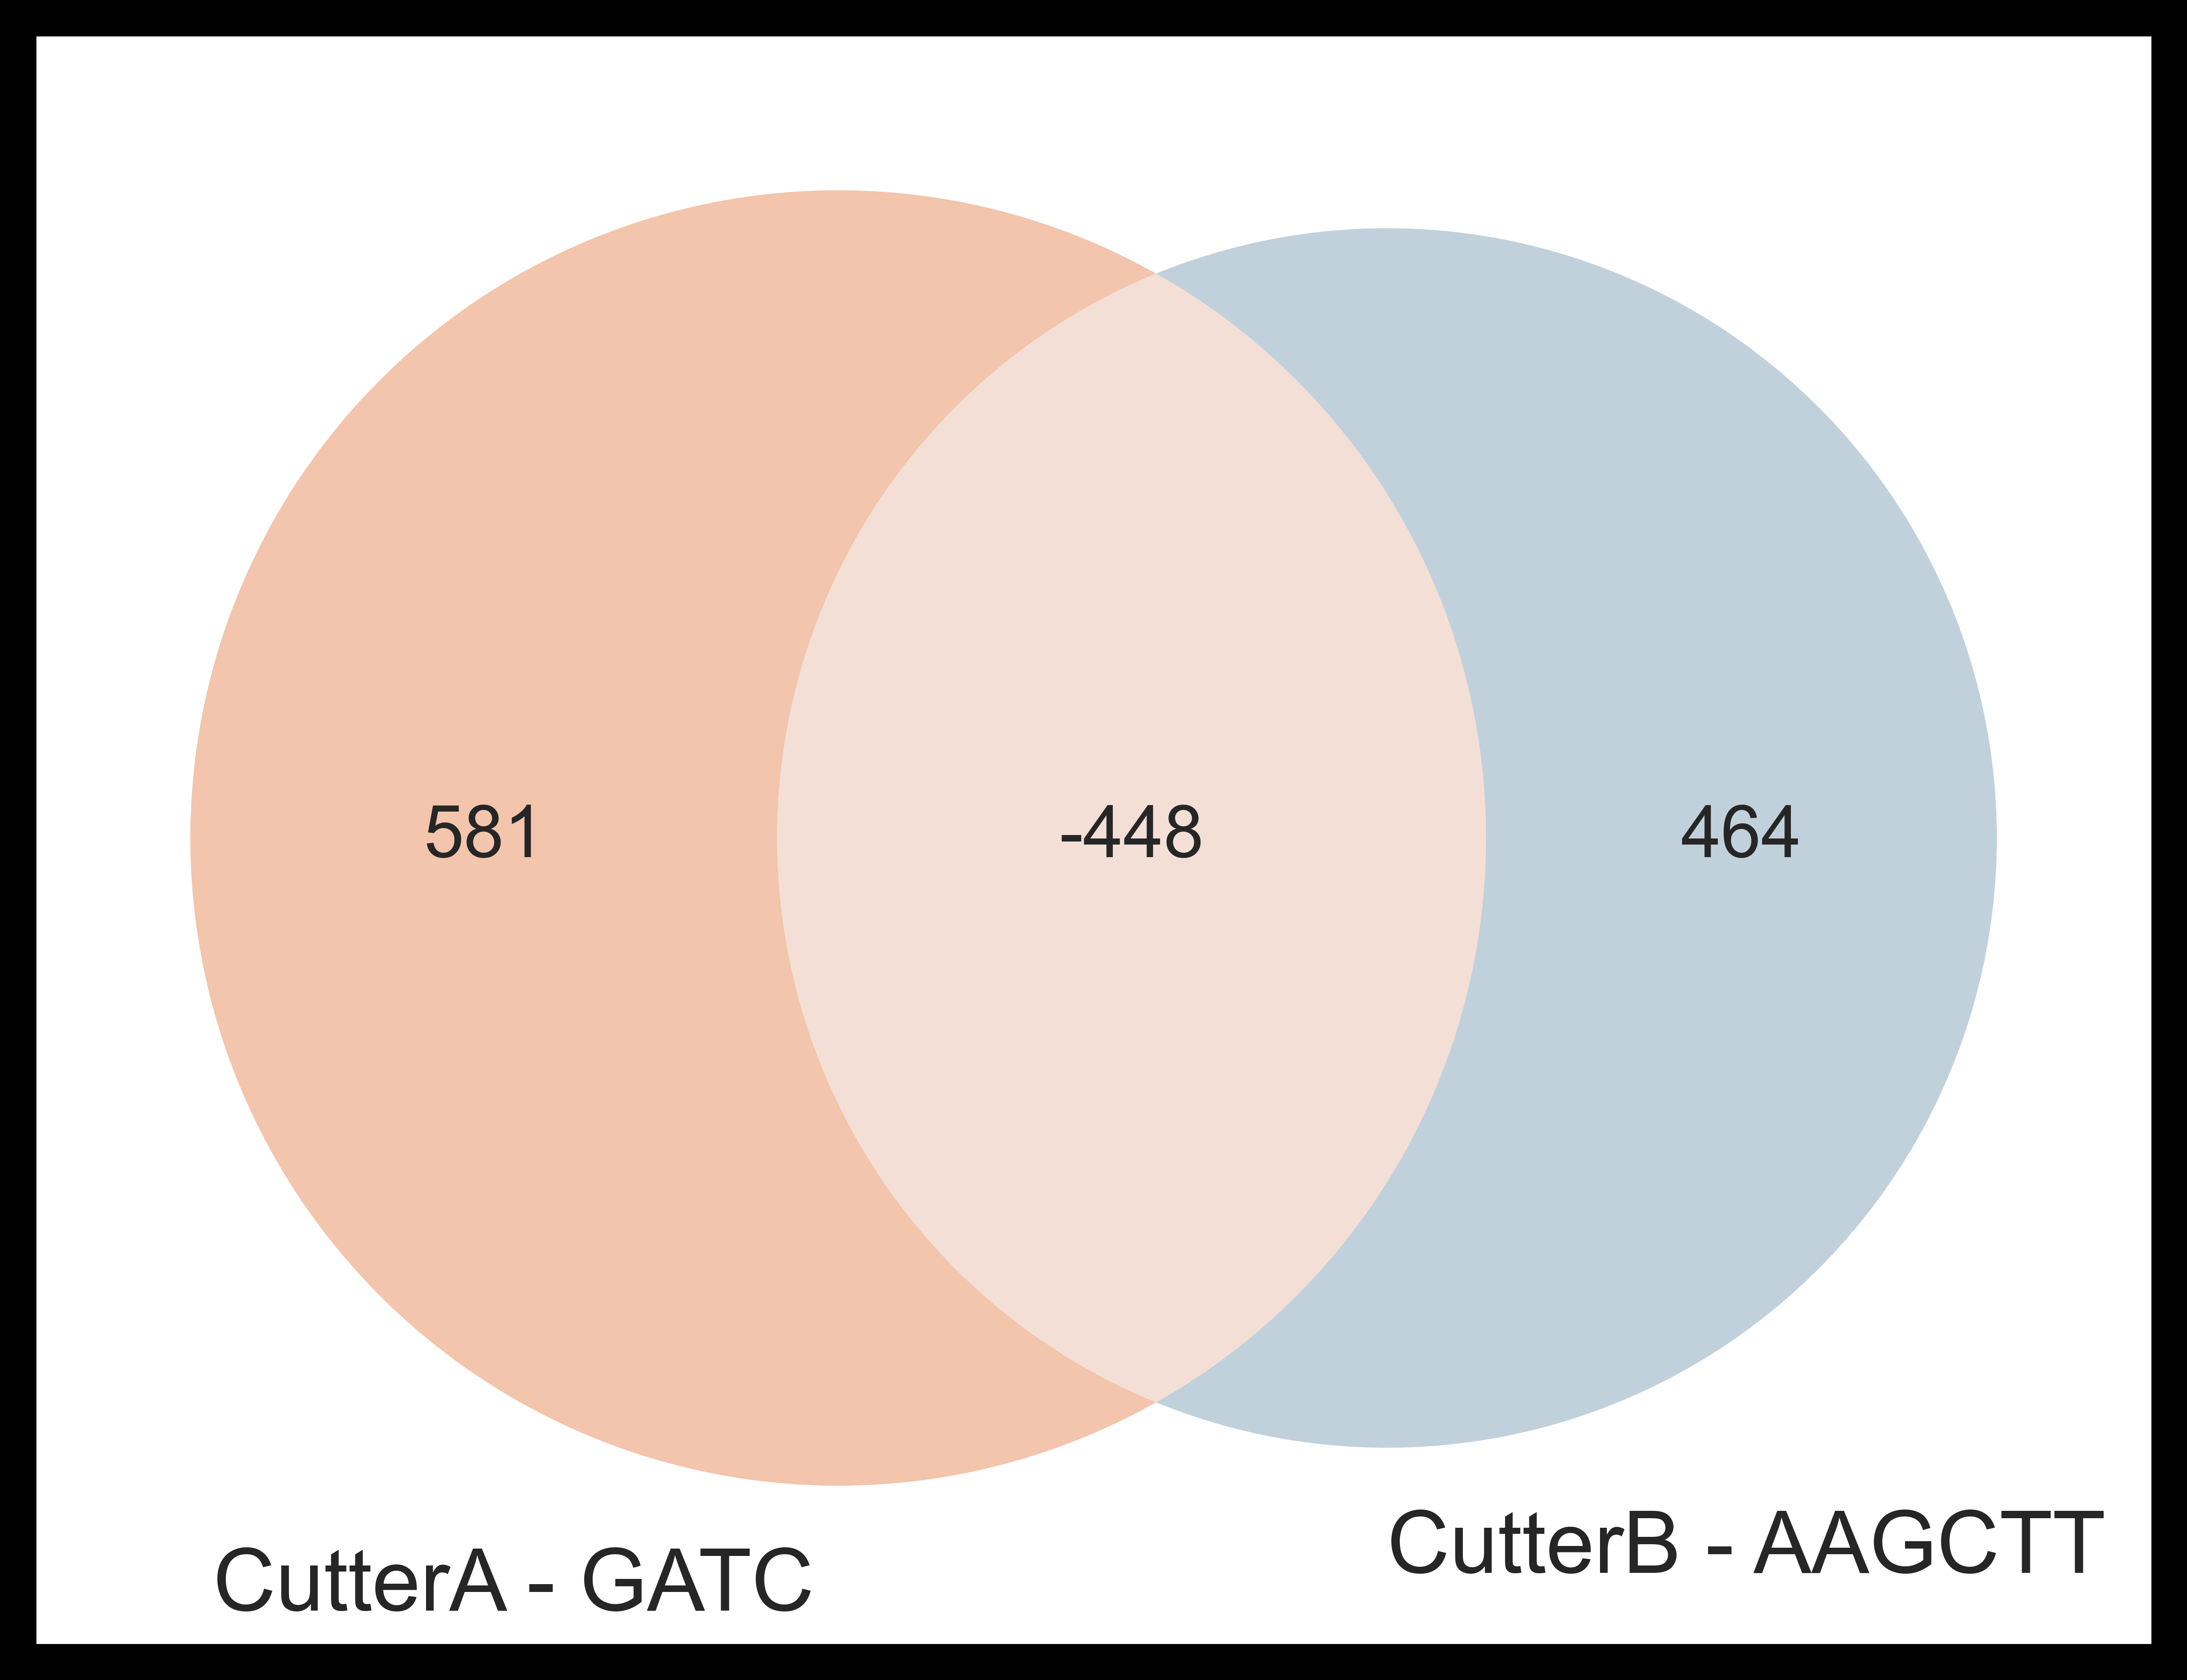

In [98]:
total = 597
middle = matchLenA+matchLenB - total
plt.figure(linewidth=10, facecolor="white", dpi=1200)
# plt.figure(linewidth=10, facecolor="white")
v = venn2(subsets = (matchLenA-middle, matchLenB-middle, middle), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
plt.show()
